In [10]:
# preparing data
from sklearn.decomposition import PCA
from methods import *
from models import *
import pandas as pd
import numpy as np
import torch
import math
import os
from os import path
import torch.nn as nn

model_name = "VAE"
DATASET = 'medical_data1'

"""___________________Hyper Parameters________________________"""
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = True
FILTER_CORRCOEF = True
REMOVE_NOISE = False
REMOVE_NOISE_THRESHOLD = 5
DENOISE = False
NOISE_FACTOR = 0.05
NOISE_FRACTION = 0.8
NORMALIZE_DATA = True
LATENT_DIM = 4
HIDDEN_DIM = 32
WEIGHT_DECAY = 1e-6
LEARNING_RATE = 1e-4
SIGMA = 1e-1
EPOCHS = 4000
ACTIVATION = 'leaky_relu'
BATCH_SIZE = 1024
INITIALIZATION = 'xavier_normal'
"""___________________________________________________________"""
#device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data1':
    raw_data = np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data1':
    #raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #raw_data = np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    raw_data = np.concatenate((np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=0)
    anomalous_data = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    #anomalous_data = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data1':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_data = np.concatenate((np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data2':
    raw_data = np.loadtxt('../data/network_flow2_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_data = np.loadtxt('../data/network_flow2_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]

train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
            filterLinearDependencies=True, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)

train_data, validation_data, test_data, anomalous_data = toTorchTensor(device, train_data, validation_data, test_data, anomalous_data)
NUM_FEATURE = len(train_data[0])
print(train_data.shape)
print(torch.max(anomalous_data))


Train data shape after trim:  (16011, 7)
Train data shape after normalize:  (16011, 7)
Train data shape after filter corrcoef:  (16011, 7)
torch.Size([16011, 7])
tensor(7.4513)


In [11]:
# initialize model
criterion = nn.MSELoss(reduction='sum')
model = VAE(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)

In [12]:
# train
loss_array = train(model, 'SGD', EPOCHS, train_data, train_data, criterion, batch_size=BATCH_SIZE, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        ,grad_limit=1e3)
torch.save(model.state_dict(), '../model/param_VAE')

epoch : 1/4000, loss = 7.038866
epoch : 2/4000, loss = 5.894337
epoch : 3/4000, loss = 4.858651
epoch : 4/4000, loss = 4.534614
epoch : 5/4000, loss = 4.345781
epoch : 6/4000, loss = 4.039528
epoch : 7/4000, loss = 3.659165
epoch : 8/4000, loss = 3.357910
epoch : 9/4000, loss = 3.154407
epoch : 10/4000, loss = 3.005167
epoch : 11/4000, loss = 2.906108
epoch : 12/4000, loss = 2.825692
epoch : 13/4000, loss = 2.757252
epoch : 14/4000, loss = 2.679843
epoch : 15/4000, loss = 2.606665
epoch : 16/4000, loss = 2.542178
epoch : 17/4000, loss = 2.447488
epoch : 18/4000, loss = 2.329383
epoch : 19/4000, loss = 2.241134
epoch : 20/4000, loss = 2.147635
epoch : 21/4000, loss = 2.089334
epoch : 22/4000, loss = 2.040801
epoch : 23/4000, loss = 1.991262
epoch : 24/4000, loss = 1.951545
epoch : 25/4000, loss = 1.917898
epoch : 26/4000, loss = 1.899341
epoch : 27/4000, loss = 1.877955
epoch : 28/4000, loss = 1.848214
epoch : 29/4000, loss = 1.836520
epoch : 30/4000, loss = 1.816736
epoch : 31/4000, lo

In [6]:
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
batch = torch.mean(train_data, dim=0, keepdim=True).expand(train_data.shape)[:BATCH_SIZE,]
code = torch.randn_like(torch.ones(len(batch), LATENT_DIM))
print(model.decode(code)[0].detach().numpy())
print(batch[0].detach().numpy())
print(criterion(model.decode(code), batch))
print('___________')
print(code[0])
print(model.decode(code[0]))
print(train_data[0])
print(criterion(model.decode(code[0]), train_data[0]))
print(torch.square(model.decode(code[0]) - train_data[0]))

[ 0.09474981 -0.36488482  0.70258427  0.63248837 -0.32521915 -0.23226106
  0.23662582]
[ 0.03359639 -0.04433621 -0.00490279 -0.00427401  0.00511861 -0.03113759
 -0.01382949]
tensor(1023.7188, grad_fn=<MseLossBackward0>)
___________
tensor([0.5644, 0.6269, 0.4055, 0.3915])
tensor([ 0.0947, -0.3649,  0.7026,  0.6325, -0.3252, -0.2323,  0.2366],
       grad_fn=<AddBackward0>)
tensor([ 0.1306, -0.4961,  0.9964,  0.8365, -0.3666, -0.3117,  0.3820])
tensor(0.1756, grad_fn=<MseLossBackward0>)
tensor([0.0013, 0.0172, 0.0863, 0.0416, 0.0017, 0.0063, 0.0211],
       grad_fn=<PowBackward0>)


In [13]:
# evaluation
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
validation_batch_size = 1
lcs_array = torch.tensor([[0 for _ in range(NUM_FEATURE)]])

difference = torch.square(model(train_data) - train_data)
lcs_array = torch.div(difference, torch.sum(difference, 1, True).expand(difference.shape))
lcs_mean = torch.mean(lcs_array, 0, True)
l = len(validation_data)
permutation = np.random.permutation(l)
for i in range(0, l, validation_batch_size):
    batch_idc = permutation[i:i+validation_batch_size]
    batch = validation_data[batch_idc,]
    loss = 0
    # compute reconstructions
    outputs = model(batch)

    #print(f"input:{batch[0].data}\noutput:{outputs[0].data}")
    
    # compute the epoch validation loss
    loss = criterion(outputs, batch).item()
    loss /= len(batch)
    #i_loss = torch.sum(torch.square(batch[0]-outputs[0]))
    #print(f"Batch Average Reconstruciton Loss:{loss}")
    lcs = torch.sum((torch.square(outputs - batch) / len(batch)), 0, keepdim=False) / loss
    #print(f"Loss Contribution Score: {(lcs)}") 

lcs_array = lcs_array[1:].detach()
lcs_mean_val = torch.mean(lcs_array, dim=0)
print("Validation average lcs: ",lcs_mean_val.numpy())

print(f"Train average loss:{criterion(model(train_data), train_data) / len(train_data)}")

print(f"Validation average loss:{criterion(model(validation_data), validation_data) / len(validation_data)}")
print("Test average loss: ", criterion(model(test_data), test_data)/len(test_data))
print("Anomalous average loss: ", criterion(model(anomalous_data), anomalous_data)/len(anomalous_data))

Validation average lcs:  [0.20081003 0.14229    0.07402912 0.14321466 0.21190153 0.11229131
 0.11546335]
Train average loss:0.49234047532081604
Validation average loss:0.5399888157844543
Test average loss:  tensor(0.5395, grad_fn=<DivBackward0>)
Anomalous average loss:  tensor(0.8990, grad_fn=<DivBackward0>)


In [14]:
# test
#model.load_state_dict(torch.load('../model/param_AE'))
model.eval()
model_name = "VAE"

# Collapse
if True:
    loss_test = []
    lcs_array_test = torch.tensor([[0 for _ in range(NUM_FEATURE)]])

    y_scores = []
    y_scores_lcs = []
    kl_div_test = []
    y_ground_truth = []
    vae_kl_test = []
    # Define KL Loss
    kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=False)
    l = len(test_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        batch = test_data[batch_idc,]
        loss = 0
        
        # compute reconstructions
        outputs = model(batch)

        #print(f"input:{batch[0].data}\noutput:{outputs[0].data}")
        
        # compute the epoch test loss
        loss = criterion(outputs, batch).item()
        vae_kl_test.append(model.KLD.item())
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(0)
        #i_loss = torch.sum(torch.square(batch[0]-outputs[0]))
        loss_test.append(loss)
        #print(f"Reconstruciton Loss:{loss}")
        
        #lcs = torch.sum((torch.square(outputs - batch)), 0, keepdim=False) / loss
        lcs = torch.square(outputs - batch) / loss
        #print(f"Loss Contribution Score: {(lcs)}")
        lcs = torch.reshape(lcs, (1, NUM_FEATURE))
        # KL Divergence
        this_kld = kl_loss(torch.log(lcs), lcs_mean.view(1, NUM_FEATURE)).detach().numpy()
        #print(this_kld)
        kl_div_test.append(this_kld)
        lcs_array_test = torch.cat((lcs_array_test, lcs), 0)

    lcs_array_test = lcs_array_test[1:].detach()
    lcs_mean_test = torch.mean(lcs_array_test, dim=0)
    print("Test average lcs: ", lcs_mean_test.numpy())
    # Loss Contribution Score
    y_scores_lcs = torch.sum((torch.square(lcs_array_test - lcs_mean)), dim=1, keepdim=False)
    lcs_array_test = lcs_array_test.numpy()

    path = "../result_lcs"
    filename = model_name +  "_lcs_normal.csv"
    pathfile = os.path.normpath(os.path.join(path, filename))
    file_present = os.path.isfile(pathfile)
    if not file_present:
        df = pd.DataFrame(lcs_array_test) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {pathfile}")
    else:
        i = 1
        while file_present:
            print("FILE PRESENT "+ str(i))
            filename = model_name + "_lcs_normal_" + str(i) + ".csv"
            pathfile = os.path.normpath(os.path.join(path, filename))
            file_present = os.path.isfile(pathfile)
            i += 1
        df = pd.DataFrame(lcs_array_test) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {pathfile}")

    #________________________________________________________________________#

    # anomaly detection test
    loss_attack =[]
    lcs_array_attack = torch.tensor([[0 for _ in range(NUM_FEATURE)]])
    kl_div_attack = []
    vae_kl_attack = []
    l = len(anomalous_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, 1):
        batch_idc = permutation[i:i+1]
        batch = anomalous_data[batch_idc,]
        
        loss = 0
        # compute reconstructions
        outputs = model(batch)
        # compute the epoch test loss
        loss = criterion(outputs, batch).item()
        vae_kl_attack.append(model.KLD.item())
        # append loss and class label
        y_scores.append(loss)
        y_ground_truth.append(1)
        loss_attack.append(loss)
        #print(f"Reconstruciton Loss:{loss}")
        
        #lcs = torch.sum((torch.square(outputs - batch)), 0, keepdim=False) / loss
        lcs = torch.square(outputs - batch) / loss
        #print(f"Loss Contribution Score: {(lcs)}")
        # KL Divergence
        this_kld = kl_loss(torch.log(lcs), lcs_mean.view(1, NUM_FEATURE)).detach().numpy()
        #print(this_kld)
        kl_div_attack.append(this_kld)

        lcs_array_attack = torch.cat((lcs_array_attack, torch.reshape(lcs, (1, NUM_FEATURE))), 0)

    lcs_array_attack = lcs_array_attack[1:].detach()
    lcs_mean_attack = torch.mean(lcs_array_attack, dim=0)
    print("Anomalous average lcs: ", lcs_mean_attack.numpy())
    # Loss Contribution Score
    y_scores_lcs = torch.cat((y_scores_lcs, torch.sum((torch.square(lcs_array_attack - lcs_mean)), dim=1, keepdim=False))).detach().numpy()
    
    lcs_array_attack = lcs_array_attack.numpy()
    
    path = "../result_lcs"
    filename = model_name + "_lcs_attack.csv"
    pathfile = os.path.normpath(os.path.join(path, filename))
    file_present = os.path.isfile(pathfile) 
    if not file_present:
        df = pd.DataFrame(lcs_array_attack) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
    else:
        i = 1
        while file_present:
            print("FILE PRESENT "+ str(i))
            filename = model_name + "_lcs_attack_" + str(i) + ".csv"
            pathfile = os.path.normpath(os.path.join(path, filename))
            file_present = os.path.isfile(pathfile)
            i += 1
        df = pd.DataFrame(lcs_array_attack) #convert to a dataframe
        #df.to_csv(pathfile, index=True) #save to file
        print(f"Saved file to {filename}")


Test average lcs:  [0.1983276  0.14170446 0.07375265 0.14230384 0.21450548 0.11444888
 0.11495711]
Saved file to ../result_lcs/VAE_lcs_normal.csv
Anomalous average lcs:  [0.18769658 0.15258624 0.0734846  0.13650368 0.202297   0.12877806
 0.11865385]


In [15]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    model.eval()
    full_code = model.encode(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)
# use TSNE to show LCS 
if True:
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    full_lcs = np.concatenate((lcs_array_test, lcs_array_attack), axis=0)
    #print(full_data.shape)
    tsne_lcs = tsne.fit_transform(full_lcs)

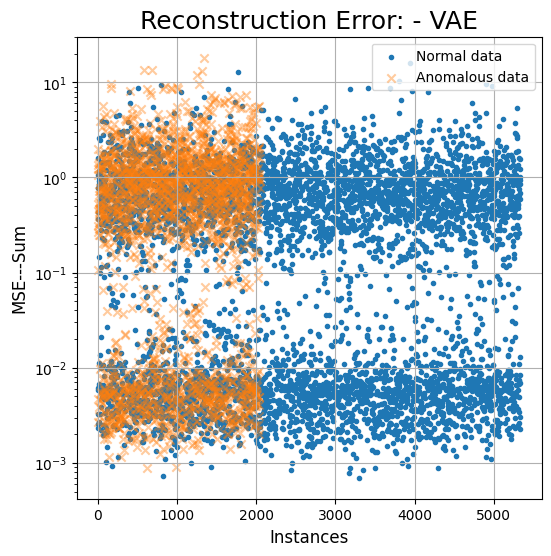

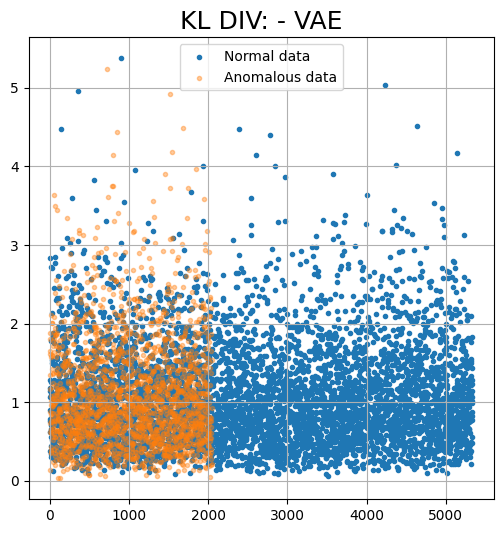

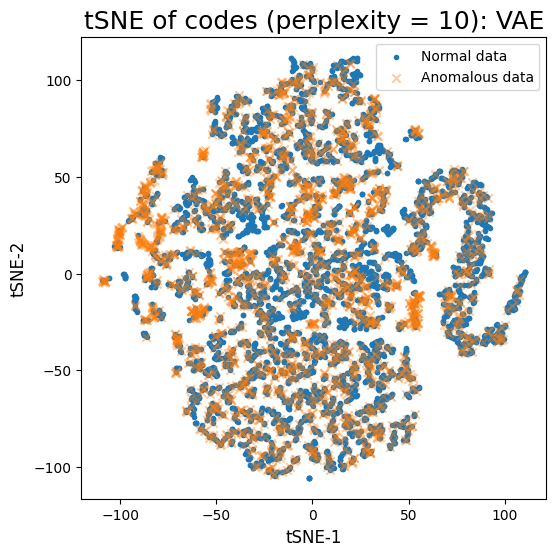

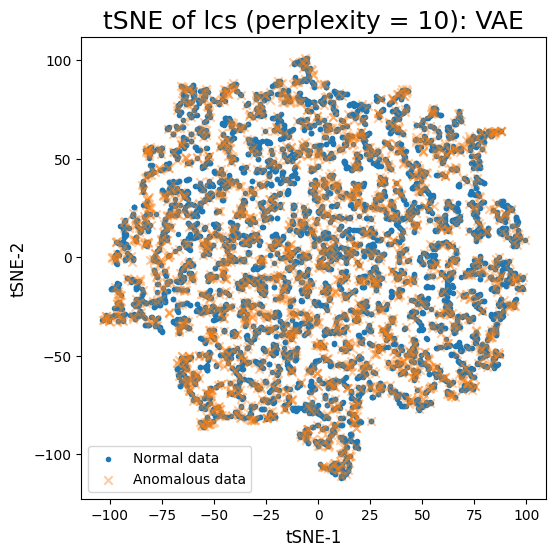

In [16]:
import matplotlib.pyplot as plt
if True:
    fig = plt.figure(figsize = (6,6))

    ax = fig.add_subplot(1,1,1)

    ax.set_xlabel('Instances', fontsize = 12)
    ax.set_ylabel('MSE---Sum', fontsize = 12)
    ax.set_yscale('log')
    #ax.set_ylim(1e2, 1e9)
    ax.set_title('Reconstruction Error: - ' + model_name, fontsize = 18)
    ax.grid()
    a = ax.scatter(np.arange(len(loss_test)), loss_test, marker=".")
    b = ax.scatter(np.arange(len(loss_attack)), loss_attack, marker="x", alpha=0.4)
    a.set_label('Normal data')
    b.set_label('Anomalous data')
    ax.legend()

    fig2 = plt.figure(figsize = (6,6))
    ax2 = fig2.add_subplot(1,1,1)
    ax2.set_title('KL DIV: - ' + model_name, fontsize = 18)
    ax2.scatter(np.arange(len(kl_div_test)), kl_div_test, marker=".").set_label('Normal data')
    ax2.scatter(np.arange(len(kl_div_attack)), kl_div_attack, marker=".", alpha=0.4).set_label('Anomalous data')
    #ax2.set_ylim(-0.1, 0.1)
    ax2.grid()
    ax2.legend()

    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1)
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()

    # Plot the result of TSNE
    fig4 = plt.figure(figsize = (6,6))
    ax4 = fig4.add_subplot(1,1,1
    #, projection='2d'
    )
    l1, l2 = len(test_data), len(anomalous_data)
    ax4.scatter(tsne_lcs[:l1,0], tsne_lcs[:l1,1], 
    #np.arange(l1), 
    marker=".").set_label('Normal data')
    ax4.scatter(tsne_lcs[l1:,0], tsne_lcs[l1:,1], 
    #np.arange(l2), 
    marker="x", alpha=0.4).set_label('Anomalous data')
    ax4.set_title(('tSNE of lcs (perplexity = ' + str(PERPLEXITY) + '): ' + model_name), fontsize = 18)
    ax4.set_xlabel('tSNE-1', fontsize = 12)
    ax4.set_ylabel('tSNE-2', fontsize = 12)
    ax4.legend()

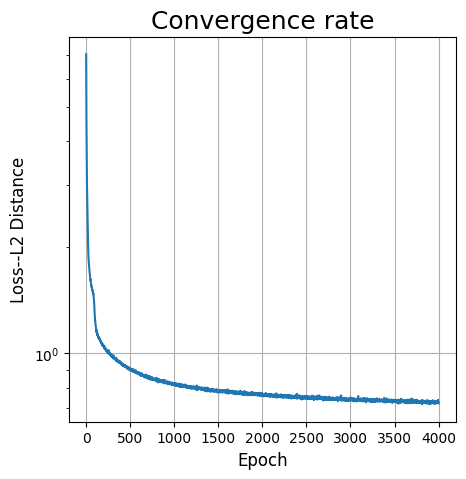

In [17]:
# Convergence Rate
if True:
    fig = plt.figure(figsize = (5, 5))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Epoch', fontsize = 12)
    ax.set_ylabel('Loss--L2 Distance', fontsize = 12)
    ax.set_yscale('log')
    #ax.set_ylim(1e5, 1e9)
    ax.set_title('Convergence rate', fontsize = 18)
    ax.grid()
    a = ax.plot(loss_array)

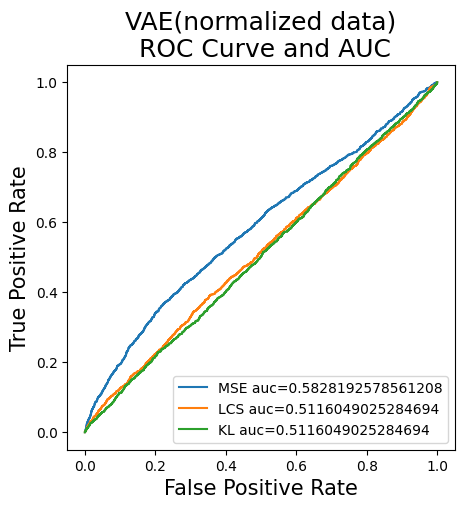

In [18]:
# ROC & AUC
from sklearn import metrics
if True:
    fig = plt.figure(figsize = (5,5))
    ax = fig.add_subplot(1,1,1) 

    fpr_MSE, tpr_MSE, _ = metrics.roc_curve(y_ground_truth,  y_scores)
    auc_MSE = metrics.roc_auc_score(y_ground_truth,  y_scores)
    fpr_LCS, tpr_LCS, _ = metrics.roc_curve(y_ground_truth,  y_scores_lcs)
    auc_LCS = metrics.roc_auc_score(y_ground_truth,  y_scores_lcs)

    y_scores_kl = kl_div_test + kl_div_attack
    fpr_KL, tpr_KL, _ = metrics.roc_curve(y_ground_truth,  y_scores_kl)
    auc_KL = metrics.roc_auc_score(y_ground_truth,  y_scores_kl)


    ax.set_title(model_name+'(normalized data)\n ROC Curve and AUC', fontsize = 18)
    ax.plot(fpr_MSE,tpr_MSE, label="MSE auc="+str(auc_MSE))
    ax.plot(fpr_LCS,tpr_LCS, label="LCS auc="+str(auc_LCS))
    ax.plot(fpr_KL,tpr_KL, label="KL auc="+str(auc_LCS))
    ax.set_xlabel("False Positive Rate", fontsize=15)
    ax.set_ylabel("True Positive Rate", fontsize=15)
    ax.legend(loc=4)

In [20]:
# VAE-GAN
#discriminator = AutoEncoder(NUM_FEATURE, output_feature=1, logit=True)
discriminator = Discriminator(NUM_FEATURE, latent_dim=64, hidden_dim=16, activation='leaky_relu', initialization='xavier_normal')
#generator = VAE(NUM_FEATURE, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, activation=ACTIVATION, initialization=INITIALIZATION, sigma=SIGMA)
generator = model
encoder = generator.encoding_layer
decoder = generator.decoding_layer
# optimizer
optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [27]:
# train
BATCH_SIZE = 512
criterion_BCE, criterion_MSE = nn.BCELoss(reduction='sum').to(device), nn.MSELoss(reduction='sum').to(device)
grad_limit = 1e2
for epoch in range(EPOCHS):
    # L_rec, L_GAN, l = 0, 0, len(train_data)
    L_rec, L_D_real, L_D_rec, L_D_noise, l = 0, 0, 0, 0, len(train_data)
    permutation = np.random.permutation(l)
    for i in range(0, l, BATCH_SIZE):
        batch_idc = permutation[i:i+BATCH_SIZE]
        batch_X = train_data[batch_idc,]
        batch_length = len(batch_X)
        # train discriminator
        discriminator.train()
        generator.eval()
        # train on real data
        zero_label, one_label = torch.zeros(batch_length, 1), torch.ones(batch_length, 1)
        loss_d_real = criterion_BCE(discriminator(batch_X), zero_label)
        # train on reconstructed data
        reconstruction= generator(batch_X)
        loss_d_rec = criterion_BCE(discriminator(reconstruction), one_label)
        #loss_d_rec = 0
        # train on data generated from latent space sample
        z_p = torch.normal(torch.zeros(batch_length, LATENT_DIM), torch.ones(batch_length, LATENT_DIM))
        generation = generator.decode(z_p)
        loss_d_noise = criterion_BCE(discriminator(generation), one_label)
        # sum up GAN Loss
        loss_gan = 2*loss_d_real + loss_d_rec + loss_d_noise
        #loss_gan = loss_d_real + loss_d_noise
        discriminator.zero_grad()
        loss_gan.backward()
        nn.utils.clip_grad_norm_(discriminator.parameters(), grad_limit)
        optimizer_D.step()
        
        # update losses for output
        L_D_real, L_D_rec, L_D_noise = L_D_real + loss_d_real, L_D_rec + loss_d_rec, L_D_noise + loss_d_noise
        #L_rec, L_GAN = L_rec + loss_Enc, L_GAN + loss_gan
    print("epoch : {}/{}, L_D_real  = {:.6f} , L_D_rec = {:.6f} , L_D_noise = {:.6f}".format(epoch + 1, EPOCHS, L_D_real/l, L_D_rec/l, L_D_noise/l))
    #print("epoch : {}/{}, VAE Loss = {:.6f} , GAN Loss = {:.6f}".format(epoch + 1, EPOCHS, L_rec/l, L_GAN/l))

epoch : 1/4000, L_D_real  = 0.163954 , L_D_rec = 34.008953 , L_D_noise = 0.000149
epoch : 2/4000, L_D_real  = 0.702290 , L_D_rec = 23.637981 , L_D_noise = 0.002043
epoch : 3/4000, L_D_real  = 2.044824 , L_D_rec = 11.652617 , L_D_noise = 0.005189
epoch : 4/4000, L_D_real  = 1.983255 , L_D_rec = 9.493434 , L_D_noise = 0.007175
epoch : 5/4000, L_D_real  = 1.813775 , L_D_rec = 8.998571 , L_D_noise = 0.008106
epoch : 6/4000, L_D_real  = 1.692640 , L_D_rec = 8.381351 , L_D_noise = 0.007603
epoch : 7/4000, L_D_real  = 1.592036 , L_D_rec = 7.883616 , L_D_noise = 0.009112
epoch : 8/4000, L_D_real  = 1.453969 , L_D_rec = 7.492021 , L_D_noise = 0.010413
epoch : 9/4000, L_D_real  = 1.346749 , L_D_rec = 6.996169 , L_D_noise = 0.014005
epoch : 10/4000, L_D_real  = 1.257474 , L_D_rec = 6.546978 , L_D_noise = 0.013023
epoch : 11/4000, L_D_real  = 1.195982 , L_D_rec = 6.041387 , L_D_noise = 0.012277
epoch : 12/4000, L_D_real  = 1.165698 , L_D_rec = 5.655737 , L_D_noise = 0.010020
epoch : 13/4000, L_D_r

In [28]:
print(discriminator(torch.rand(5, NUM_FEATURE)))

tensor([[1.0000],
        [0.0185],
        [0.0199],
        [0.0113],
        [1.0000]], grad_fn=<SigmoidBackward0>)


In [31]:
pred_threshold = 0.5
print("Test Recall: ", (torch.sum(discriminator(anomalous_data) > pred_threshold) / len(anomalous_data)).item())
print("Test Precision: ", (torch.sum(discriminator(anomalous_data) > pred_threshold) / (torch.sum(discriminator(anomalous_data) > pred_threshold) + torch.sum(discriminator(test_data) > pred_threshold))).item())
print(torch.sum(discriminator(anomalous_data) > pred_threshold))
print(torch.sum(discriminator(test_data) > pred_threshold))

Test Recall:  0.12561094760894775
Test Precision:  0.22603341937065125
tensor(257)
tensor(880)


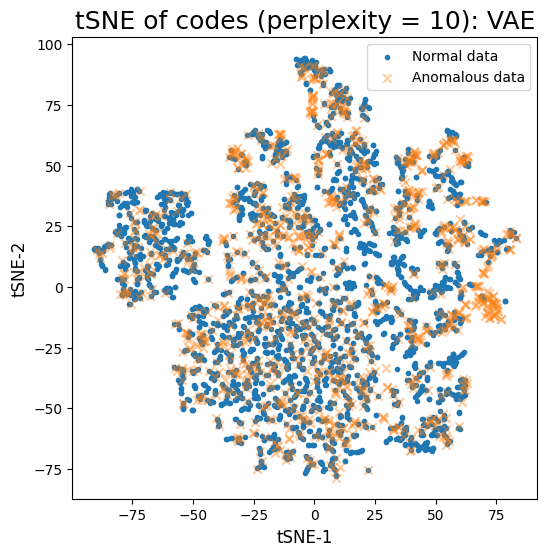

In [ ]:
# use TSNE to show code distribution
PERPLEXITY = 10
if True:
    generator.eval()
    full_code = generator.encode(torch.cat((test_data, anomalous_data), dim=0)).detach().numpy()
    full_label = [0 for _ in range(len(test_data))] + [1 for _ in range(len(anomalous_data))]
    from sklearn.manifold import TSNE

    # We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, perplexity=PERPLEXITY)
    #print(full_data.shape)
    tsne_code = tsne.fit_transform(full_code)

if True:
    fig3 = plt.figure(figsize = (6,6))
    ax3 = fig3.add_subplot(1,1,1)
    l1, l2 = len(test_data), len(anomalous_data)
    ax3.scatter(tsne_code[:l1,0], tsne_code[:l1,1], marker=".").set_label('Normal data')
    ax3.scatter(tsne_code[l1:,0], tsne_code[l1:,1], marker="x", alpha=0.4).set_label('Anomalous data')
    ax3.set_title(('tSNE of codes (perplexity = ' + str(PERPLEXITY) + '): ' + 'VAE-GAN'), fontsize = 18)
    ax3.set_xlabel('tSNE-1', fontsize = 12)
    ax3.set_ylabel('tSNE-2', fontsize = 12)
    ax3.legend()



In [ ]:
train_X, train_Y, test_X, test_Y = preProcessData_LogisticRegression(raw_data, anomalous_data, trim=TRIM_DATA, trim_threshold=0.98, normalize=NORMALIZE_DATA,
    filterLinearDependencies=True, filter_threshold=0.98, removeNoise=REMOVE_NOISE, noise_threshold=REMOVE_NOISE_THRESHOLD)
#
train_X, train_Y, test_X, test_Y = toTorchTensor(device, train_X, train_Y, test_X, test_Y)
pred_threshold = 0.5
##
test_X = torch.tensor(np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]).to(torch.float)
test_Y = torch.ones(len(test_X), 1).to(torch.float)
##
parameters = {}
parameters["Train precision"] = torch.sum(torch.logical_and((discriminator(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(discriminator(train_X) > pred_threshold)
parameters["Train recall"] = torch.sum(torch.logical_and((discriminator(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(train_Y == 1)
parameters["Test precision"] = torch.sum(torch.logical_and((discriminator(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(discriminator(test_X) > pred_threshold)
parameters["Test recall"] = torch.sum(torch.logical_and((discriminator(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
print(parameters)

Train data shape after trim:  (8005, 6)
Train data shape after normalize:  (8005, 6)
Train data shape after filter corrcoef:  (8005, 6)
removeNoise = True ---- remaining Data Shape =  (7900, 6)
{'Train precision': tensor(0.), 'Train recall': tensor(0.), 'Test precision': tensor(nan), 'Test recall': tensor(0.)}
